In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn nltk tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load your CSV file
df = pd.read_csv("Social Media Emotion Dataset.csv")

# Show basic info
print(df.head())
print(df['label'].value_counts())


                                                text     label
0            i just feel horribly selfish fraudulent     Angry
1                        @Talula25 How have you been   Neutral
2  @dilyaela nope not really only a sweatshirt.  ...  Surprise
3                               ordered my new shirt     Happy
4  you don't seem real at all  i was just saying ...   Neutral
label
Neutral     23586
Happy       23377
Sad         16671
Angry        9373
Surprise     2840
Name: count, dtype: int64


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_text)


In [5]:
X = df['clean_text']
y = df['label']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [6]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()


In [7]:
model = Sequential()
model.add(Dense(512, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_tfidf, y_train, validation_split=0.1, epochs=10, batch_size=64, callbacks=[es])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 102s 115ms/step - accuracy: 0.5533 - loss: 1.1219 - val_accuracy: 0.6910 - val_loss: 0.8329
Epoch 2/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 138s 111ms/step - accuracy: 0.7638 - loss: 0.6530 - val_accuracy: 0.6902 - val_loss: 0.8582
Epoch 3/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 146s 115ms/step - accuracy: 0.8245 - loss: 0.4864 - val_accuracy: 0.6785 - val_loss: 0.9301
Epoch 4/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 138s 111ms/step - accuracy: 0.8786 - loss: 0.3407 - val_accuracy: 0.6783 - val_loss: 1.1515


475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step
Accuracy: 68.38%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.79      0.66      0.72      1875
       Happy       0.73      0.70      0.72      4676
     Neutral       0.61      0.75      0.67      4717
         Sad       0.71      0.66      0.68      3334
    Surprise       0.72      0.16      0.27       568

    accuracy                           0.68     15170
   macro avg       0.71      0.59      0.61     15170
weighted avg       0.69      0.68      0.68     15170



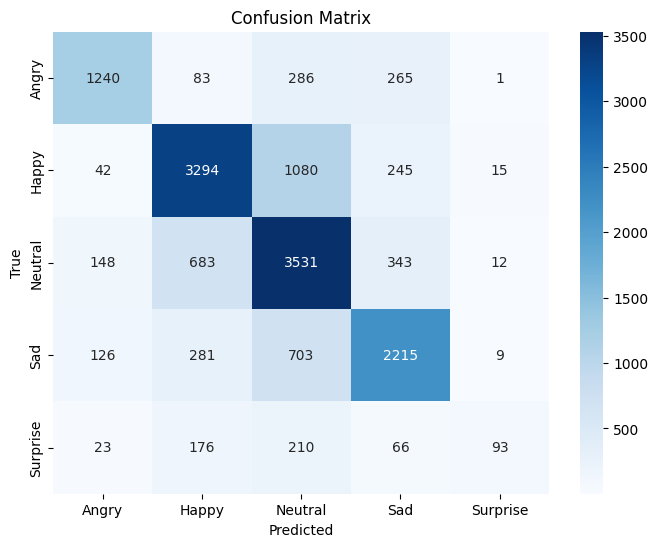

In [8]:
y_pred = model.predict(X_test_tfidf)
y_pred_labels = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))

# Optional: Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
